# 25 - Synthetic Difference-in-Differences
 
In previous chapters, we looked into both Difference-in-Differences and Synthetic Control methods for identifying the treatment effect with panel data (data where we have multiple units observed across multiple time periods). It turns out we can merge both approaches into a single estimator. This new Synthetic Difference-in-Differences estimation procedure manages to exploit advantages of both methods while also increasing the precision (decreasing the error bars) of the treatment effect estimate.
 
We will discuss Synthetic Difference-in-Differences mostly in the case of **block treatment assignment**. This means we observe multiple units across time and, at the **same** time, some units are treated while other units remain untreated. We can visualize this by a matrix of treatment assignments $D$, where the **columns of the matrix are units** and **rows of the matrix are time periods**.
 
$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 1 & 1 \\
    0 & 0 & 0 & \dots & 1 & 1 \\
\end{bmatrix}
$$
 
To make things more concrete, let's follow along with the example of estimating the impact of Proposition 99 in California's Cigarette consumption. In this case, we only have one treated unit, California, that gets treated (passed Proposition 99) at some point in time (November 1988, to be precise). If we say California is the last column of the matrix, we get something like this:
 
$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 0 & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 \\
\end{bmatrix}
$$
 
Notice that here we are only talking about the case where all treated units get the treatment **at the same point in time**. In the end, we will discuss how to handle **staggered addoption treatment assignment**, where the treatment is gradually rolled out to units, causing them to get it at different points in time. The only thing we'll require in that design is that, once a unit is treated, it doesn't roll back to being untreated.
 
Back to the simple case, where we have all units treated at the same time, we can simplify the treatment assignment matrix to four blocks, each represented by another matrix. In general, as we move down the matrix, we are moving forward in time. We will also group the treated units to the right of the matrix. As a result, the first block in our matrix (top left) correspond to the control units prior to the treatment period; the second one (top right) corresponds to the treated units prior to the treatment period; the third block (bottom left) contains the control units after the treatment period and the fourth block (bottom right) is the treated unit after the treatment period. The treatment indicator is zero everywhere except for the block with the treated units after the treatment period. 
 
$$
D = \begin{bmatrix}
    \pmb{0} & \pmb{0} \\
    \pmb{0} & \pmb{1} \\
\end{bmatrix}
$$
 
This assignment matrix will lead to the following outcome matrix:
 
$$
Y = \begin{bmatrix}
    \pmb{Y}_{pre, co} & \pmb{Y}_{pre, tr} \\
    \pmb{Y}_{post, co} & \pmb{Y}_{post, tr} \\
\end{bmatrix}
$$
 
Again, notice how the post-treatment period is on the bottom and the treated units are to the right.
 
In our example of estimating the effect of Proposition 99, the outcome $Y$ is cigarette sales. We use $pre$ and $post$ to represent the period prior and after the treatment respectively and $co$ and $tr$ to represent the control and treated unit respectively. 
 
We will use the above matrix representation whenever we talk about estimating the synthetic control weights, but there is also another data representation which is useful, especially if we are talking about DiD. In this representation, we have a table with 5 columns: one representing the units, one representing the time periods, the outcome column and two boolean columns flagging the treated units and the treatment period. The number of rows in this table is the number of units $N$ times the number of periods $T$. Here you can see what it looks like for the Proposition 99 data:

In [1]:
import numpy as np
import pandas as pd
from toolz import curry, partial
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

pd.set_option('display.max_columns', 10)

In [2]:
data = (pd.read_csv("data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state": {3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [3]:
data.query("state=='california'").query("year.between(1986, 1990)")

,state,year,cigsale,treated,after_treatment
78,california,1986,99.699997,True,False
79,california,1987,97.500000,True,False
80,california,1988,90.099998,True,False
81,california,1989,82.400002,True,True
82,california,1990,77.800003,True,True


If we want to go from this table to the matrix representation we discussed earlier, all we have to do is pivot the table by time (year) and unit (state). We'll be going back and forth between these two representations, as one is more convenient for DiD and the other, for Synthetic Controls estimation. 

In [4]:
data_piv = data.pivot("year", "state", "cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns if c != "california"})

data_piv.head()[["state_1", "state_2", "state_4", "state_38", "state_39", "california"]].round()

state,state_1,state_2,state_4,state_38,state_39,california
year,,,,,,
1970,90.0,100.0,125.0,106.0,132.0,123.0
1971,95.0,104.0,126.0,105.0,132.0,121.0
1972,101.0,104.0,134.0,109.0,140.0,124.0
1973,103.0,108.0,138.0,110.0,141.0,124.0
1974,108.0,110.0,133.0,112.0,146.0,127.0


In terms of potential outcomes, we can go back to the outcome matrix to review the causal inference goal here. Since the treatment is only rolled out to the treated unit after the treatment period, we observe the potential outcome $Y_0$ everywhere in the matrix, except for the bottom right block. 
 
$$
Y = \begin{bmatrix}
    \pmb{Y}(0)_{pre, co} & \pmb{Y}(0)_{pre, tr} \\
    \pmb{Y}(0)_{post, co} & \pmb{Y}(1)_{post, tr} \\
\end{bmatrix}
$$
 
Our goal is to estimate the $ATT =  \pmb{Y}(1)_{post, tr} -  \pmb{Y}(0)_{post, tr}$. For that, we need to somehow estimate the missing potential outcome $\pmb{Y}(0)_{post, tr}$. In words, we need to know what would have happened to the treated unit in the post-treatment period had it not been treated. With that in mind, a good place to start is by reviewing both Diff-in-Diff and Synthetic Control. At first, it looks like they are each doing very different things to estimate that missing potential outcome. Combining them sure feels weird. However, both methods have more in common than we might think. 

## Diff-in-Diff Revisited
 
In the Diff-in-Diff chapter, we got the treatment effect by estimating the following linear model.
 
$$
Y_{it} = \beta_0 + \beta_1 Post_t + \beta_2 Treated_i + \beta_3 Treated_i  Post_t + e_{it}
$$
 
Where `post` is a time dummy indicating that the period is after the treatment and `treated` is a unit dummy marking units as being part of the treated group. If we estimate this model in the California example, we get -27.34 as the estimated $ATT$, indicating a strong negative effect of Proposition 99. This would mean that per capita consumption of cigarettes fell by 27 packs due to Proposition 99. 

In [5]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


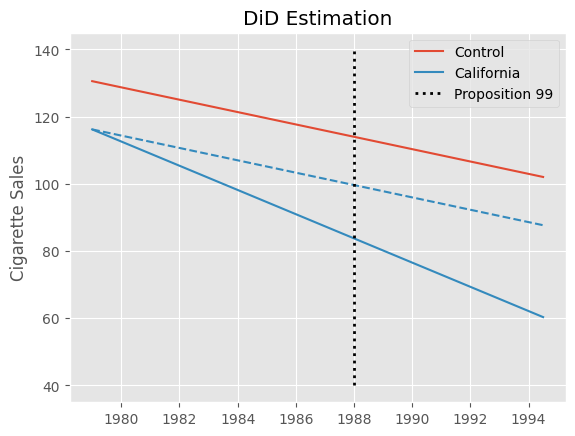

In [6]:
pre_year = data.query("~after_treatment")["year"].mean()
post_year = data.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y0 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y1 = post_treat_y0 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel("Cigarette Sales")
plt.legend();

This estimate should be taken with a grain of salt, though. We know that Diff-in-Diff requires the trend in the control group to be equal to that of the treated group in the absence of the treatment. Formally, $E[Y(0)_{post, co} - Y(0)_{pre, co}] = E[Y(0)_{post, tr} - Y(0)_{pre, tr}]$. This is an untestable assumption, but looking at the pre-treatment trend of California (the treated unit) and the other states, we can get a feeling for how plausible it is. Specifically, we can see that the trend in `cigsale` for California is not parallel to the other states, at least in the pre-treatment periods. Cigarette sales in California are decreasing faster than the average of the control states, even prior to the treatment. If this trend extends beyond the pre-treatment period, the DiD estimator will be downward biased, meaning that the true effect is actually less extreme than the one we've estimated above.

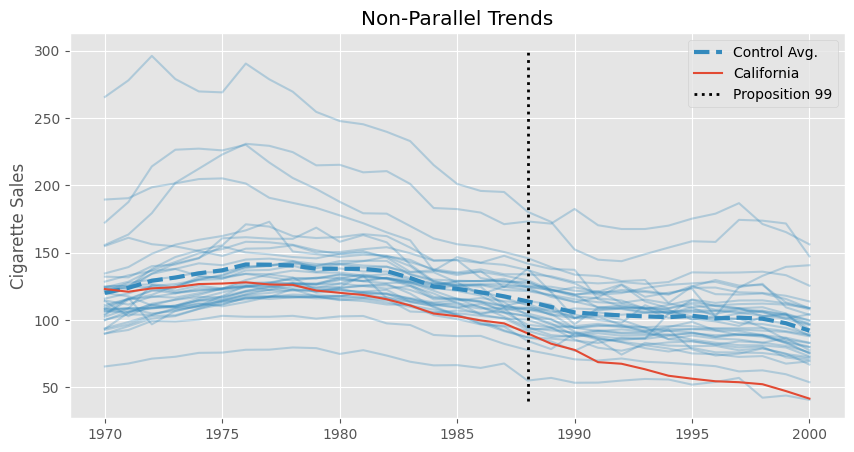

In [7]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(data_piv.drop(columns=["california"]).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

The problem of non-parallel trends is where Synthetic Control comes into play in the Synthetic Diff-in-Diff model. But we are getting ahead of ourselves. Regardless of DiD being a valid model for the data above, what is interesting about it is that we can recast it into the Two-Way Fixed-Effects formulation. To frame DiD like this, we fit unit ($\alpha_i$) and time ($\beta_t$) averages, alongside the treatment indicator.
 
$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$
 
In this formulation, the unit effects capture the difference in intercepts for each unit while the time effects capture the general trend across both treated and control units. To implement this, we could either add time and unit dummies to the model or demean the data. In this process, we subtract the average across both time and units from both treatment and outcome variables:
 
$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_i  - \bar{Y}_t\\
\ddot{D}_{it} = D_{it} - \bar{D}_i - \bar{D}_t
$$
 
Where, $\bar{X}_i$ is the average across all time periods for unit $i$ and $\bar{X}_t$ is the average across all units for time $t$: 
 
$$
\ddot{Y}_{it} = Y_{it} - T^{-1}\sum_{t=0}^{t=T} Y_{it}  - N^{-1}\sum_{i=0}^{i=N} Y_{it}\\
\ddot{D}_{it} = D_{it} - T^{-1}\sum_{t=0}^{t=T} D_{it} - N^{-1}\sum_{i=0}^{i=N} D_{it}
$$
 
After demeaning, a simple regression of the outcome on the treatment indicator (`treat*post`) yields the difference in difference estimator.

In [8]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("state")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-119.1647,0.333,-358.379,0.000,-119.817,-118.512
treat,-27.3491,4.283,-6.385,0.000,-35.753,-18.945


As you can see, we get the exact same parameter as before. After all, both approaches are simply different ways of looking at the same DiD estimator. However, the reason this formulation is much more interesting for our purpose is that it allows us to see how DiD is actually quite similar to Synthetic Controls. Take a very close look at the TWFE formulation above. Notice that it is a regression problem with time effects and unit effects. But notice how there are no weights in the optimization objective. That is the main difference between Diff-in-Diff and Synthetic Controls, as we will see shortly. 
 
## Synthetic Controls Revisited
 
In the canonical Synthetic Control estimator, we find unit (state) weights that minimize the difference between the pre-treated outcome of the treated unit and the weighted average of the pre-treated outcome of the control units (in a setting with no covariates). We also constrain the weights to be all positive and sum up to one. To find those weights, we solve the following optimization problem:
 
$$
\hat{w}^{sc} = \underset{w}{\mathrm{argmin}} \ ||\pmb{\bar{y}}_{pre, tr} - \pmb{Y}_{pre, co} \pmb{w}_{co}||^2_2 \\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$
 
where the outcome $\pmb{Y}_{pre, co}$ is a $T_{pre}$ by $N_{co}$ matrix, where the columns are the units and the rows are the time periods. $\pmb{w}_{co}$ is a $N_{co}$ by 1 column vector, with one entry for each unit. Finally, $\pmb{\bar{y}}_{pre, tr}$ is a $T_{pre}$ by 1 column vector, where each entry is the time average of the treated units in the pre-treatment period. This is why we sometimes call Synthetic Control a horizontal regression. In most regression problems, the units are the rows of the matrix, but here they are the columns. Hence, we are regressing the average outcome of the treated units on the control units.
 
Once we find the weights that solve the problem above, we can multiply them by the control units at all time periods to get a synthetic control for the treated unit:
 
$$
\pmb{y}_{sc} = \pmb{Y}_{co}\hat{\pmb{w}}^{sc}
$$
 
The idea here is that $\pmb{y}_{post, sc}$ is a good estimator for our missing potential outcome $Y(0)_{post, tr}$. If that is the case, the $ATT$ is simply the average of the treated unit in the post-treatment period minus the average of the synthetic control, also in the post treatment period.
 
$$
\hat{\tau} =  \bar{y}_{post, tr} - \bar{y}_{post, sc}
$$


In [9]:
from sc import SyntheticControl

sc_model = SyntheticControl()

y_co_pre = data.query("~after_treatment").query("~treated").pivot("year", "state", "cigsale")
y_tr_pre = data.query("~after_treatment").query("treated")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = data.query("~treated").pivot("year", "state", "cigsale").dot(sc_weights)

att = data.query("treated")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

SC ATT:  -19.5136


This estimate is much smaller than the one we got with Diff-in-Diff. Synthetic Controls can accommodate non-parallel pre-treatment trends much better, so it is not susceptible to the same bias as Diff-in-Diff. Rather, the process of baking a Synthetic Control enforces parallel trends, at least in the pre-treatment period. As a result, the estimate we get is much smaller and much more plausible. 
 
We can visualize this estimation process by plotting the realized outcome for California alongside the outcome of the synthetic control. We also plot as dashed lines the post intervention average of both California and the synthetic control. The difference between these lines is the estimated $ATT$.

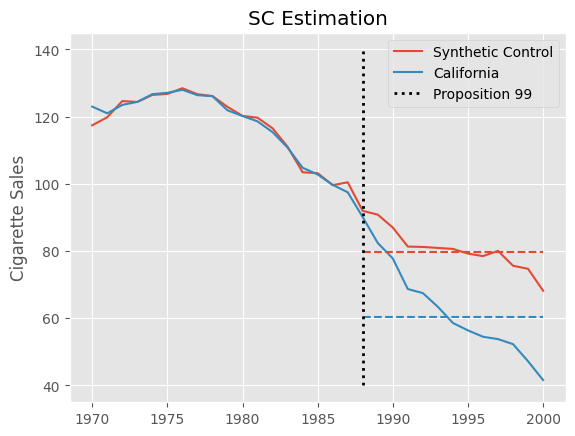

In [10]:
plt.plot(sc, label="Synthetic Control")
plt.plot(sc.index, data.query("treated")["cigsale"], label="California", color="C1")

calif_avg = data.query("treated")["cigsale"][sc.index > 1988].mean()
sc_avg = sc[sc.index > 1988].mean()

plt.hlines(calif_avg, 1988, 2000, color="C1", ls="dashed")
plt.hlines(sc_avg, 1988, 2000, color="C0", ls="dashed")

plt.title("SC Estimation")
plt.ylabel("Cigarette Sales")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend();

Interestingly enough, we can also recast the Synthetic Control estimator as solving the following optimization problem, which is quite similar to the Two-Way Fixed-Effects formulation we used for Diff-in-Diff
 
$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$
 
where the $\hat{w}^{sc}_i$ weights for the control units are estimated from the optimization problem we saw earlier. For the treated unit,  the weights are simply $1/N_{tr}$ (uniform weighting). 
 
Notice the difference between SC and DiD here. First, Synthetic Control adds unit weights $\hat{w}^{sc}_i$ to the equation. Second, we have time fixed effects $\beta_t$ but no unit fixed effect $\alpha_i$, nor an overall intercept  $\mu$. 
 
To verify that these two formulations are actually equivalent, here is the code for it, which yields the exact same $ATT$ estimate. 

In [11]:
@curry
def demean_time(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

data_w_cs_weights = data.set_index("state").join(sc_weights).fillna(1/len(sc_weights))

formula = f"""cigsale ~ -1 + treat"""

mod = smf.wls(formula,
              data=data_w_cs_weights
              .assign(treat = data_w_cs_weights["after_treatment"]*data_w_cs_weights["treated"])
              .pipe(demean_time(col_to_demean="treat"))
              .pipe(demean_time(col_to_demean="cigsale")),
              weights=data_w_cs_weights["sc_w"]+1e-10)

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,-19.5136,13.289,-1.468,0.142,-45.586,6.559


We just saw how the two approaches, SC and DiD, are actually closely related. Now, we are ready to talk about Synthetic Diff-in-Diff. As you can probably guess, we will just add weights to the DiD estimator or unit fixed-effects to the Synthetic Control estimator. 
 
![img](data/img/sdid/both-pills.png)
 
## Synthetic Diff-in-Diff
 
Before we jump right into the Synthetic Diff-in-Diff estimator, let me just reproduce the same equations we saw earlier for SC and DiD, which will ease the comparison.
 
$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$
 
$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$
 
Next, just like I promised, we can easily merge the equations above into one which will contain elements from both of them:
 
$$
\hat{\tau}^{sdid} = \underset{\mu, \alpha, \beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \hat{w}^{sdid}_i \hat{\lambda}^{sdid}_t \bigg\}
$$
 
As you can see, we've added back the $\alpha_i$ unit fixed effects. We've also kept the unit weights $\hat{w}_i$. But there is something new, which is the time weights $\hat{\lambda}_t$. Don't worry. There is nothing fancy about them. Remember how the unit weights $w_i$ minimized the difference between the control units and the average of treated units? In other words, we use them to match the pre-trend of the treated and control groups. The time weight does the same thing, but for the periods. That is, it minimizes the difference between the pre and post-treated periods for the controls. 
 
$$
\hat{\lambda}^{sdid} = \underset{\lambda}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{post, co} - (\pmb{\lambda}_{pre} \pmb{Y}_{pre, co} +  \lambda_0)||^2_2 \\
\text{s.t } \ \sum \lambda_t = 1 \text{ and } \ \lambda_t > 0 \ \forall \ t
$$
 
Again, $\pmb{Y}_{pre, co}$ is a $T_{pre}$ by $N_{co}$ matrix of outcomes where the rows represent time periods and the columns represent the units. But now $\bar{\pmb{y}}_{post, co}$ is a 1 by $N_{co}$ row vector, where each entry is the time average outcome for that control unit in the post-treatment period. Finally, $\pmb{\lambda}_{pre}$ is a 1 by $T_{pre}$ row vector, with one entry for each pretreatment period. Another way to see this is by noticing that the unit weights $w$ were post-multiplying the outcome matrix $\pmb{Y}_{pre, co} \pmb{w}_{co}$. This means we were regressing the average outcome **for each unit** of the treated group on the outcome of the units in the control group. Now, we are flipping that problem on its head, regressing the average outcome **for each post-treatment time period** of the control group on the outcome of the same control units, but in the pre-treatment period.
 
As for the time weights in the post-treated periods, we just set them to one over the number of post-treated periods $1/T_{post}$ (again, doing uniform weighting). Notice that we also have an intercept $\lambda_0$. We do this to allow the post-treatment period to be above or below all the pre-treatment periods, which is the case in many applications with a clear positive or negative trend.
 
If all of this seems a bit abstract, maybe code will help you understand what is going on.

In [12]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(year_col, state_col, outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        
        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

The first thing we do in this code is to filter out the treated group. Then, we pivot the pre-treated data so that we have the matrix $\pmb{Y}_{pre,co}$. Next, we group the post-treatment data to get the average outcome for each control unit in the post-treatment period. We then add a row full of ones to the top of $\pmb{Y}_{pre,co}$, which will serve as the intercept. Finally, we regress $\bar{\pmb{y}}_{post, co}$ on the pre-treated periods (the rows of $\pmb{Y}_{pre,co}$) to get the time weights $\lambda_t$. Notice how we add the constraints to have the weights sum up to 1 and be non-negative. Finally, we toss the intercept away and store the time weights in a series. 
 
Here is the result we get by running the code above to find the time weights in the Proposition 99 problem. Notice that all periods except for 1986, 87 ans 88 get zero weights. This means that a weighted average of only the last 3 periods is enough to balance pre and post treatment periods.

In [13]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

year
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

To understand a bit more about the role of these weights, we can plot $\hat{\pmb{\lambda}}_{pre} \pmb{Y}_{pre, co} +  \hat{\lambda}_0$ as a horizontal line in the pretreatment period that doesn't get zeroed out. Next to it, we plot the average outcome in the post-treatment period. Notice how they align perfectly. We also show the estimated time weights in red bars and in the secondary axis.

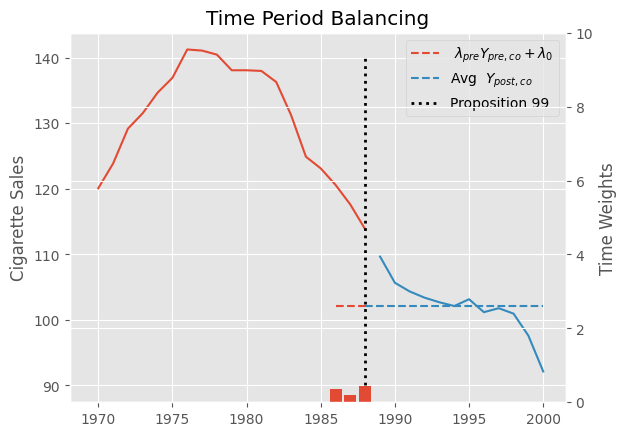

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean())
ax.plot(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean())

intercept = -15.023877689807628
ax.hlines((data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean() * time_weights).sum() - 15, 1986, 1988,
          color="C0", ls="dashed", label=""" $\lambda_{pre} Y_{pre, co} + \lambda_0$""")
ax.hlines(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean().mean(), 1988, 2000,
          color="C1", ls="dashed", label="""Avg  $Y_{post, co}$""")
ax.vlines(x=1988, ymin=90, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()

plt.title("Time Period Balancing")
plt.ylabel("Cigarette Sales");

ax2 = ax.twinx()
ax2.bar(time_weights.index, time_weights, label="$\lambda$")
ax2.set_ylim(0,10)
ax2.set_ylabel("Time Weights");

Now that we learned what are the time weights $\lambda_t$ in the Synthetic Diff-in-Diff estimator and how to estimate them, let's turn our attention to the unit weights $w_i$. And no, unfortunately they are not just like the ones we get when using traditional Synthetic Controls. The first difference between them is that we also allow for an intercept $w_0$. We do this because we don't need the treated unit and synthetic control to have the same level anymore. Since we will throw DiD into the mix, we only need to make the synthetic control and treated unit have parallel trends.
 
The next difference is that we add a $L_2$ penalty to the weights. This helps non-zero weights to be more distributed across the control units, as opposed to having just a few of them contributing to the synthetic control. The $L_2$ penalty ensures we don't have very big weights, which forces us to use more units. 
 
 
$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{pre, tr} - (\pmb{Y}_{pre, co} \pmb{w}_{co} +  w_0)||^2_2 + \zeta^2 T_{pre} ||\pmb{w}_{co}||^2_2\\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$


There is also this $\zeta^2$ term, which is theoretically motivated, but very complicated to explain, so I will unfortunately leave it as a bit of a mystery. In the reference, you can check the original article, which explains them. We define it like this:
 
$$
\zeta = (N_{tr}* T_{post})^{1/4}\sigma(\Delta_{it})
$$
 
where $\Delta_{it}$ is the first difference in the outcomes $Y_{it} - Y_{i(t-1)}$ and $\sigma(\Delta_{it})$ is the standard deviation of this difference. Here is the code to compute it.

In [15]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

As for the unit weights, there is nothing particularly new in them. We can reuse a lot of the code from the function to estimate the time weights. We only need to be careful about the dimensions, since the problem is now upside down.

In [16]:
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(year_col, state_col, outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

First, we calculate $\zeta$ using the function we defined earlier and filter out the post-treatment period. Next, we pivot the pre-treatment data to get the $\bar{\pmb{y}}_{pre, tr}$ matrix of outcomes. Then, we add a column full of ones to the beginning of the $\bar{\pmb{y}}_{pre, tr}$ matrix. This column will allow us to estimate the intercept. With all of that, we define the optimization objective, which includes the $L_2$ penalty on the weights. Finally, we toss the intercept away and store the estimated weights in a series.
 
If we use this code to estimate the unit weights in the Proposition 99 problem, here is the result we get for the first 5 states:

In [17]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3).head()

state
1   -0.000
2   -0.000
4    0.057
5    0.078
6    0.070
Name: unit_weights, dtype: float64

These unit weights also define a synthetic control that we can plot alongside the outcome of California. We'll also plot the traditional synthetic control we've estimated earlier alongside the one we've just estimated plus the intercept term. This will give us some intuition on what is going on and the difference between what we just did and traditional Synthetic Control.

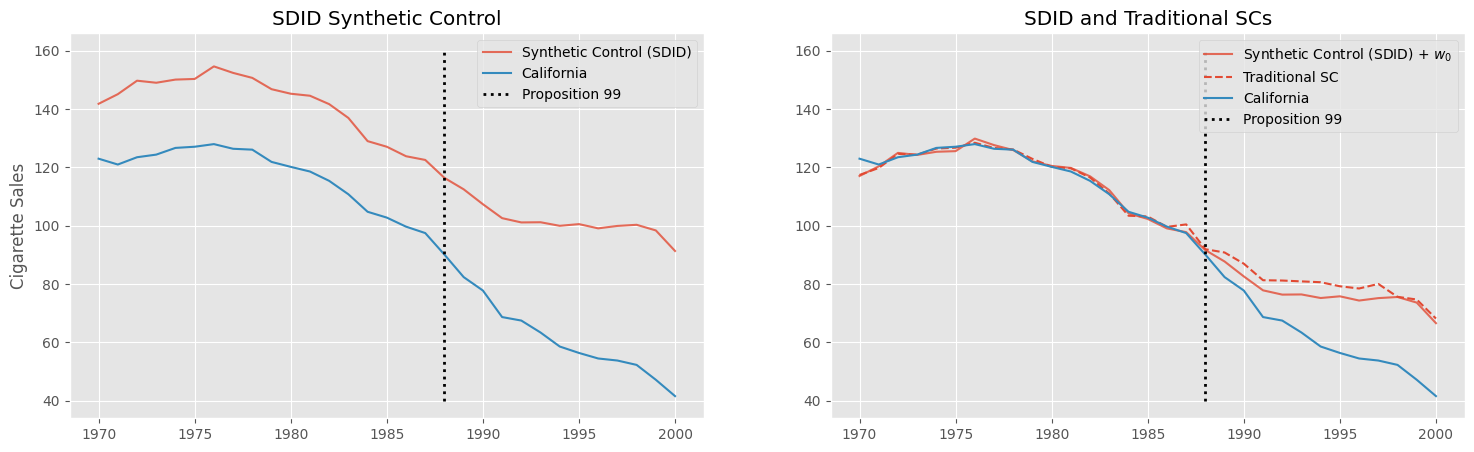

In [18]:
intercept = -24.75035353644767
sc_did = data_piv.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
ax1.plot(data_piv["california"], label="California", color="C1")
ax1.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")

ax1.legend()
ax1.set_title("SDID Synthetic Control")
ax1.set_ylabel("Cigarette Sales");

ax2.plot(data_piv.index, sc_did+intercept, label="Synthetic Control (SDID) + $w_0$", color="C0", alpha=.8)
ax2.plot(data_piv.index, sc, label="Traditional SC", color="C0", ls="dashed")
ax2.plot(data_piv["california"], label="California", color="C1")
ax2.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
ax2.legend()
ax2.set_title("SDID and Traditional SCs");

As we can see in the first plot, the obvious difference is that this new synthetic control is no longer on top of California. That's because we've included an intercept, which allows the treated unit to be on an arbitrarily different level than its synthetic control. This new Synthetic Control method is built to have the same pretreatment trend as the treated unit, but not necessarily the same level. 
 
In the second plot, we shift this new SC by adding back the intercept we've removed earlier. This puts it on top of the treated unit, California. For comparison, we show the traditional SC we've fitted earlier as the red dashed line. Notice that they are not the same. This difference comes both from the fact that we allowed for an intercept and from the $L_2$ penalty, which pushed the weights towards zero.
 
Now that we have both time $\hat{\lambda}_t$ and unit $\hat{w}_t$ weights, we can proceed to running the Diff-in-Diff part of the Synthetic DiD estimator. For this part, it is better if we work with the data in the format of a table with $N$ by $T$ rows, where we have columns for the states, the years, the outcome, the post-treatment indicator and the treated unit indicator. To that table, we will add the time and unit weights. Since the time weight is in a series with a time index and the unit weights is in another series with unit index, we can simply join everything together.

In [19]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):

    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: data[post_col].mean(),
                 unit_w.name: data[treat_col].mean()})
        .assign(**{"weights": lambda d: (d[time_w.name]*d[unit_w.name]).round(10)})
        .astype({treat_col:int, post_col:int}))

This joining process will leave `null` for the unit weights in the treated group and for the time weights in the post-treatment period. Fortunately, because we use uniform weighting in both cases, it is pretty easy to fill out those `null`s. For the time weights, we fill with the average of the post-treatment dummy, which will be $1/T_{post}$; for the unit weights, we fill with the average of the treated dummy, which will be $1/N_{tr}$. Finally, we multiply both weights together.
 
Here is the result we get by running this code on the Proposition 99 data:

In [20]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600034e-14,-1.360835e-16,0.0
1,1971,1,95.400002,0,0,-4.582315e-14,-1.360835e-16,0.0
2,1972,1,101.099998,0,0,-5.274190e-14,-1.360835e-16,0.0
3,1973,1,102.900002,0,0,-5.766356e-14,-1.360835e-16,0.0
4,1974,1,108.199997,0,0,-5.617979e-14,-1.360835e-16,0.0


Finally, all we have to do is estimate a Diff-in-Diff model with the weights we've just defined. The parameter estimate associated with the interaction term for the post-treatment period and treated dummy will be the Synthetic Difference-in-Differences estimate for the $ATT$.

In [21]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

did_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.965,61.278,0.000,116.551,124.261
after_treatment,-19.1905,2.166,-8.859,0.000,-23.440,-14.941
treated,-25.2601,12.427,-2.033,0.042,-49.641,-0.879
after_treatment:treated,-15.6054,13.700,-1.139,0.255,-42.483,11.272


This estimate is much smaller than the one we get with Diff-in-Diff, but that is not surprising. As we've already discussed, the Diff-in-Diff estimator is probably biased in this case, since we have pretty good reasons to question the parallel trends assumption. What is perhaps less obvious is why the SDID estimate is smaller than the traditional SC estimate. If we go back and look at the SC plot, we can see that cigarette sales in California started to fall below its synthetic control prior to Proposition 99. This is probably due to the fact that traditional Synthetic Control has to match treated and control units in the entire pre-treatment period, causing it to miss one year or the other. This is less of an issue in SDID, since the time weights allow us to focus just on the periods that are more similar to the post-intervention period. In this case, those were precisely the three years anteceding Proposition 99. 
 
To grasp what SDID is doing, we can plot the Diff-in-Diff lines for the treated (California) and the SDID Synthetic Control. Notice how we are projecting the trend we see in the synthetic control onto the treated unit to get the counterfactual $Y(0)_{tr, post}$. The difference between the two solid purple lines is the estimated $ATT$. We start those lines in 1987 to show how the time weights zero out all periods but 1986, 87 and 88. The time weights are also shown in the small plot down below.

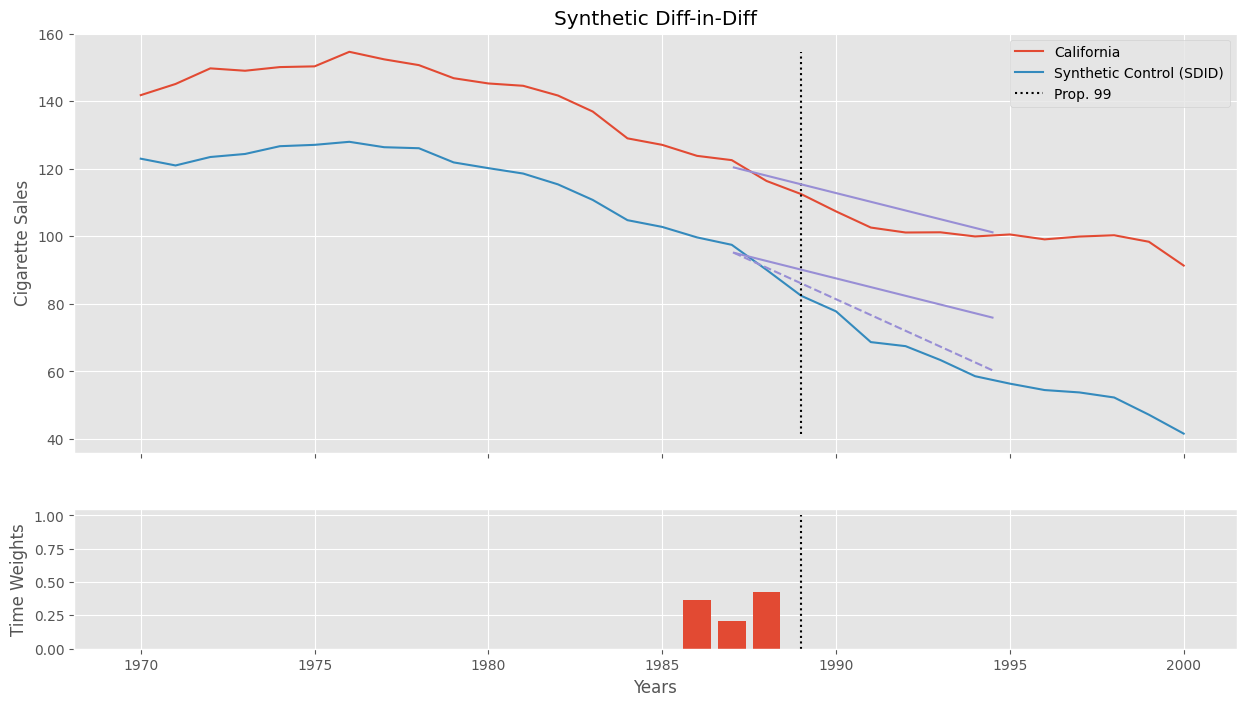

In [22]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc_did, label="California")
ax1.plot(data_piv.index, data_piv["california"], label="Synthetic Control (SDID)")
ax1.vlines(1989, data_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")
ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

The above estimator estimates the $ATT$ which is the effect of Propostion 99 on California averaged out across all post-treatment time periods. But, from the above plot, it looks like the effect increases over time. What if we want to take that into account? Fortunately, it is very straightforward to do that.
 
Before we move on, just a word of caution about the above estimator. You should not trust the standard errors or confidence intervals reported by the regression we just ran. They don't reflect the variance in estimating the weights. We will take a look at how to do proper inference briefly, but first, let's see how to deal with effect heterogeneity across time.
 
## Time Effect Heterogeneity and Staggered Adoption
 
Fortunately, it is incredibly easy to estimate one effect for each time period using SDID. All we have to do is run it multiple times, one for each time period. To be more precise, let's say we have the following treatment assignment matrix, with just 4 time periods and 3 units. The last unit is the treated one.
 
$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$
 
Running SDID with the above matrix would give us the average $ATT$ across periods 3 and 4. What we can do to estimate the effect on each period individually is simply to partition the problem into two, one for each post-treatment time period. Then, we run SDID on the data where we only keep post-treatment period 3 and again on the data where we only keep post-treatment period 4. That is, we run SDID on each of the following matrices individually.
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$
 
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$
 
To do that, it would be best if we first merge all the steps of SDID into a single function. That is, estimating the unit and time weights and running DiD.

In [23]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # join weights into DiD Data
    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)
    
    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    
    return did_model.params[f"{post_col}:{treat_col}"]


synthetic_diff_in_diff(data, 
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

-15.605398746342328

Now that we have a way of easily running SDID, we can run it multiple times, filtering out all the post-treatment periods except the one for which we want the effect.

In [24]:
effects = {year: synthetic_diff_in_diff(data.query(f"~after_treatment|(year=={year})").dropna(), 
                                        outcome_col="cigsale",
                                        year_col="year",
                                        state_col="state",
                                        treat_col="treated",
                                        post_col="after_treatment")
           for year in range(1989, 2001)}

effects = pd.Series(effects)

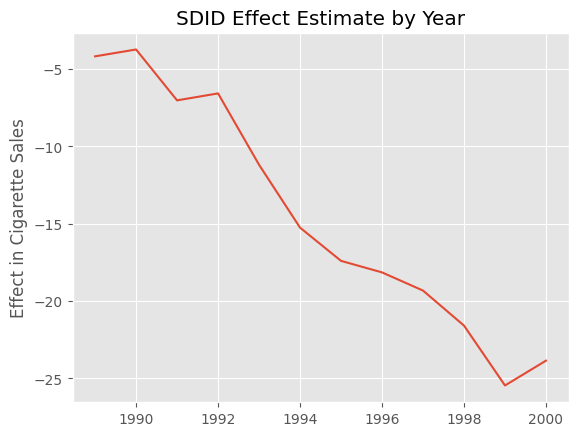

In [25]:
plt.plot(effects);
plt.ylabel("Effect in Cigarette Sales")
plt.title("SDID Effect Estimate by Year");

As expected, the effect gets bigger as time passes. It starts small, but it gradually increases to what seems like a decrease in consumption of 25 cigarette packs per capita in 2020. 
 
Conveniently, running multiple SDID will also be important to deal with the staggered adoption case. With staggered addoption design, we have multiple treated units, which get the treatment at different time periods. For example, going back to our very simple assignment matrix, with 3 units and 4 time periods, let's say unit 1 never gets the treatment, unit 2 gets the treatment at period 4 and unit 3 gets the treatment at period 3. This would result in the following matrix
 
$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$
 
Notice that SDID can't handle that matrix, because we don't have a clear definition about what is a pre-treatment period (before time 4, in the case of the second unit or before period 3, in the case of the second unit) or what is a control unit (unit 2 could be a control for the treatment starting at period 3). The key in solving this is realizing we can delete columns (units) or rows (time periods) in that matrix in order to go back to the block assignment design.
 
For example, we can create two block matrices from the one above by first deleting the 3rd time period and then another one where we delete the 4th time period.
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$
 
 
The result is two block matrices, which means we can run SDID in both of them. The result will be two $ATT$ estimates, which we can then combine with a weighted average, where the weights are the proportion of treated time and periods in each block. In our example, the weight for $ATT_1$ would be $2/3$ and the weight for $ATT_2$ would be 1/3.
 
Alternatively, we could also have 2 block designs by removing columns, which would result in the following matrices
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1  \\
    0_2 & 0_2  \\
    0_3 & 0_3  \\
    0_4 & 1_4  \\
\end{bmatrix}
$$
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 \\
    0_2 & 0_2 \\
    0_3 & 1_3 \\
    0_4 & 1_4 \\
\end{bmatrix}
$$
 
where $D_1$ has units 1 and 2 and $D_2$ has units 1 and 4. 
 
Since we already saw how to estimate SDID for different time periods, let's look at this approach where we filter out units. Since we don't originally have a staggered adoption design in our Proposition 99 data, let's instead simulate one. We'll create 3 new states from our data and pretend they pass a law similar to Proposition 99, but in the year 1993. Maybe they were impressed with the results in California and wanted to try in their states too. Once they do, this law that they pass decreases cigarette consumption by 3% each year. We can visualize the average cigarette consumption for those  new states to better understand what is going on. In dashed black, we have the year in which these states pass this anti-tobacco law. 

In [26]:
np.random.seed(1)
n = 3
tr_state = (data
            .query(f"state.isin({list(np.random.choice(data['state'].unique(), n))})")
            .assign(**{
                "treated": True,
                "state": lambda d: "new_" + d["state"].astype(str),
                "after_treatment": lambda d: d["year"] > 1992
            })
            # effect of 3% / year
            .assign(**{"cigsale": lambda d: np.random.normal(d["cigsale"] - 
                                                             d["cigsale"]*(0.03*(d["year"] - 1992))*d["after_treatment"], 1)}))

new_data = pd.concat([data, tr_state]).assign(**{"after_treatment": lambda d: np.where(d["treated"], d["after_treatment"], np.nan)})

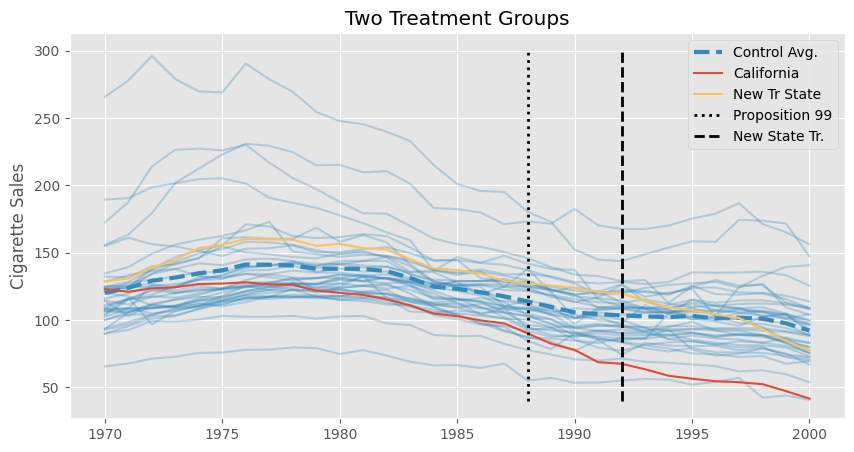

In [27]:
new_data_piv = new_data.pivot("year", "state", "cigsale")

new_tr_states = list(filter(lambda c: str(c).startswith("new"), new_data_piv.columns))

plt.figure(figsize=(10,5))
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states), color="C1", alpha=0.3)
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")

plt.plot(new_data_piv["california"], color="C0", label="California")
plt.plot(new_data_piv[new_tr_states].mean(axis=1), color="C4", label="New Tr State")

plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.vlines(x=1992, ymin=40, ymax=300, linestyle="dashed", lw=2, label="New State Tr.", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Two Treatment Groups");

We finally have this staggered adoption data. Now, we need to figure out how to filter out some states so we can break the problem into multiple block assignment cases. First, we can group states by when they passed the law. The following code does exactly that.

In [28]:
assignment_blocks = (new_data.query("treated & after_treatment")
                     .groupby("state")["year"].min()
                     .reset_index()
                     .groupby("year")["state"].apply(list).to_dict())

assignment_blocks

{1989: ['california'], 1993: ['new_13', 'new_38', 'new_9']}

As you can see, we have two groups of states. One with only California, which was treated starting in 1989, and another with the three new states we've created, which were all treated starting in 1993. Now, we need to run SDID for each of those groups. We can easily do that, but keeping just the control units plus one of those groups. There is a catch, though. The `after_treatment` column will have a different meaning, depending on which group we are looking at. If we are looking at the group containing only California, `after_treatment` should be `year >= 1989`; if we are looking at the group with the new states, it should be `year >= 1993`. Fortunately, this is pretty easy to account for. All we need is to recreate the `after_treatment` in each iteration. 

In [29]:
staggered_effects = {year: synthetic_diff_in_diff(new_data
                                                   .query(f"~treated|(state.isin({states}))")
                                                   .assign(**{"after_treatment": lambda d: d["year"] >= year}),
                                                  outcome_col="cigsale",
                                                  year_col="year",
                                                  state_col="state",
                                                  treat_col="treated",
                                                  post_col="after_treatment")
                     for year, states in assignment_blocks.items()}

staggered_effects

{1989: -15.605398746342328, 1993: -17.24943592017881}

Not surprisingly, the $ATT$ estimate for the first group, the one with only California, is exactly the same as the one we've seen before. The other $ATT$ refers to the one we get with the new group of states. We have to combine them into a single $ATT$. This can be done with the weighted average we've explained earlier. 
 
First, we calculate the number of treated entries (`after_treatment & treated`) in each block. Then, we combine the $ATT$s using those weights. 

In [30]:
weights = {year: sum((new_data["year"] >= year) & (new_data["state"].isin(states)))
           for year, states in assignment_blocks.items()}

att = sum([effect*weights[year]/sum(weights.values()) for year, effect in staggered_effects.items()])

print("weights: ", weights)
print("ATT: ", att)

weights:  {1989: 12, 1993: 24}
ATT:  -16.701423528899983


Here, we have a total of 36 treatment instances: the usual 12 post-treatment periods for California plus 8 treatment periods (1993-2000) for each of the three new treatment states we've introduced. With that in mind, the weight for the first $ATT$ is $12/36$ and for the second $ATT$, $24/36$, which combines to the result above.
 
## Placebo Variance Estimation
 
This chapter is getting a bit too long, but there is one promise we haven't fulfilled yet. Remember how we said, in the very beginning, that SDID has better precision (lower error bars) when compared to Synthetic Controls? The reason is that the time and unit fixed effects in SDID capture a ton of the variation in the outcome, which in turn, reduces the variance of the estimator.
 
Of course I wouldn't ask you to take my word for it, so next, we'll show how to place a confidence interval around the SDID estimate. It turns out there are many solutions to this problem, but only one that fits the case for a single treated unit, which is the case we have here since only California was treated. The idea is to run a series of placebo tests, where we pretend a unit from the control pool is treated, when it actually isn't. Then, we use SDID to estimate the $ATT$ of this placebo test and store its result. We re-run this step multiple times, sampling a control unit each time. In the end, we will have an array of placebo $ATT$s. The variance of this array is the placebo variance of the SDID effect estimate, which we can use to construct a confidence interval.
 
$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$
 
$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$
 
In order to implement this, the first thing we need is a function which creates the placebo. This function will filter out the treated units, sample a single control unit and flip the `treated` column for that control unit from 0 to a 1.

In [31]:
def make_random_placebo(data, state_col, treat_col):
    control = data.query(f"~{treat_col}")
    states = control[state_col].unique()
    placebo_state = np.random.choice(states)
    return control.assign(**{treat_col: control[state_col] == placebo_state})

In [32]:
np.random.seed(1)
placebo_data = make_random_placebo(data, state_col="state", treat_col="treated")

placebo_data.query("treated").tail()

,state,year,cigsale,treated,after_treatment
1204,39,1996,110.300003,True,True
1205,39,1997,108.800003,True,True
1206,39,1998,102.900002,True,True
1207,39,1999,104.800003,True,True
1208,39,2000,90.500000,True,True


In the example above, we've sampled state 39 and we are now pretending that it was treated. Notice how the `treated` column was flipped to `True`.
 
The next thing we need is to compute the SDID estimate with this placebo data and repeat that a bunch of times. The next function does that. It runs the `synthetic_diff_in_diff` function to get the SDID estimate, but instead of passing the usual data, we pass the result of calling `make_random_placebo`. We do that multiple times to get an array of SDID estimates and, finally, compute the square root of the variance of this array, which is just the standard deviation.

In [33]:
from joblib import Parallel, delayed # for parallel processing


def estimate_se(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0, njobs=4):
    np.random.seed(seed=seed)
    
    sdid_fn = partial(synthetic_diff_in_diff,
                      outcome_col=outcome_col,
                      year_col=year_col,
                      state_col=state_col,
                      treat_col=treat_col,
                      post_col=post_col)
    
    effects = Parallel(n_jobs=njobs)(delayed(sdid_fn)(make_random_placebo(data, state_col=state_col, treat_col=treat_col))
                                     for _ in range(bootstrap_rounds))
    
    return np.std(effects, axis=0)


In [34]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment")

The standard deviation can then be used to construct confidence intervals much like we described in the formula above.

In [35]:
print(f"Effect: {effect}")
print(f"Standard Error: {se}")
print(f"90% CI: ({effect-1.65*se}, {effect+1.65*se})")

Effect: -15.605398746342328
Standard Error: 9.912089792199428
90% CI: (-31.960346903471383, 0.7495494107867273)


Notice that the $ATT$ is not significant in this case, but what's more interesting here is to compare the standard error of the SDID estimate with the one we get from traditional Synthetic Control.

In [36]:
def synthetic_control(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(year_col, state_col, outcome_col)
                     .values)
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control@w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    sc = (data
          .query(f"~{treat_col}")
          .pivot(year_col, state_col, outcome_col)
          .values) @ w.value
    
    y1 = data.query(f"{treat_col}").query(f"{post_col}")[outcome_col]
    att = np.mean(y1 - sc[-len(y1):])
    
    return att


def estimate_se_sc(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_control(make_random_placebo(data, state_col=state_col, treat_col=treat_col), 
                                 outcome_col=outcome_col,
                                 year_col=year_col,
                                 state_col=state_col,
                                 treat_col=treat_col,
                                 post_col=post_col)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


effect_sc = synthetic_control(data,
                              outcome_col="cigsale",
                              year_col="year",
                              state_col="state",
                              treat_col="treated",
                              post_col="after_treatment")


se_sc = estimate_se_sc(data,
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

In [37]:
print(f"Effect: {effect_sc}")
print(f"Standard Error: {se_sc}")
print(f"90% CI: ({effect_sc-1.65*se_sc}, {effect_sc+1.65*se_sc})")

Effect: -19.513629763998537
Standard Error: 11.241934948296466
90% CI: (-38.06282242868771, -0.964437099309368)


Notice how the error for synthetic control is higher than for SDID. Again, that is because SDID captures a lot of the variance in the outcome via its time and unit fixed effects. With this, we fulfill the promise we made earlier. But, before we close, it is worth mentioning that we can also use the same procedure to estimate the variance to make a confidence interval around the effect we've estimated for each post-treatment time period. All we need to do is run the code above once for each time period. Just keep in mind that this might take some time to run, even with the parallelization we've implemented.

In [38]:
standard_errors = {year: estimate_se(data.query(f"~after_treatment|(year=={year})").dropna(), 
                                     outcome_col="cigsale",
                                     year_col="year",
                                     state_col="state",
                                     treat_col="treated",
                                     post_col="after_treatment",
                                     njobs = 1)
                   for year in range(1989, 2001)}

standard_errors = pd.Series(standard_errors)

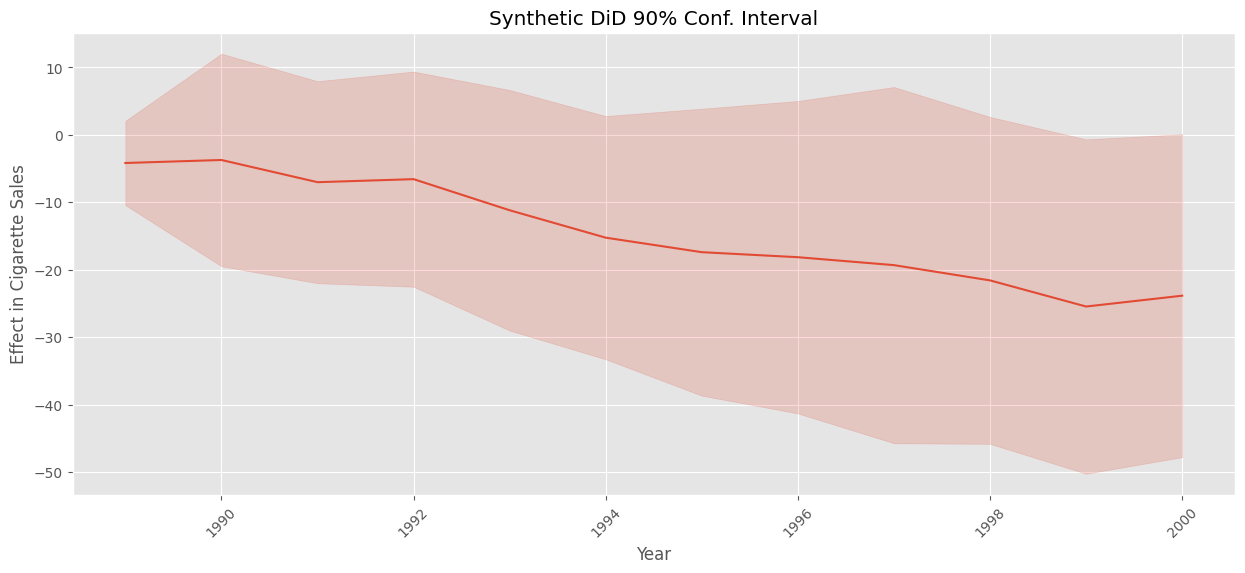

In [39]:
plt.figure(figsize=(15,6))

plt.plot(effects, color="C0")
plt.fill_between(effects.index, effects-1.65*standard_errors, effects+1.65*standard_errors, alpha=0.2,  color="C0")

plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year")
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45);

## Key Concepts

Synthetic-Diff-in-Diff (SDID) draws inspiration from both Diff-in-Diff and Synthetic Control, which brings advantages from both models.  Like SC, SDID still works with multiple periods when pre-treatment trends are not parallel. However, unlike SC, SDID estimates unit weights to build a control unit which is only parallel to the treated group (it doesn't have to match its level). From DID, SDID leverages time and unit fixed effects, which helps to explain a lot of the variance in the outcome, which in turn reduces the variance of the SDID estimator. Synthetic-Diff-in-Diff also introduces some new ideas of its own. First, there is an additional $L2$ penalty in the optimization of the unit weights which makes them more spread out across control units. Second, SDID allows for an intercept (and hence, extrapolation) when building such weights. Third, SDID introduces the use of time weights, which are not present in either DID nor SC. For this reason, I wouldn't say SDID is just merging SC and SDID. It is rather building something new, inspired by these two approaches. I also wouldn't say that SDID is better or worse than traditional Synthetic Control. Each of them have different properties that might be appropriate or not, depending on the situation. For example, you might find yourself in a situation where allowing the extrapolations from SDID is dangerous. In which case, SC might be a good alternative.  


## References 
 
This chapter is essentially an explainer to the *Synthetic Difference in Differences* (2019) article, by Dmitry Arkhangelsky, Susan Athey, David A. Hirshberg, Guido W. Imbens and Stefan Wager. Additionally, I would love to recognize Masa Asami for his python implementation of SDID, pysynthdid. His code helped me make sure I didn't have any bugs in mine, which was extremely helpful. 
 
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).